In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
%load_ext autoreload
%autoreload 2
# print('TF version:', tf.__version__ , '\nGPU available:', tf.config.list_physical_devices('GPU'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read Data
- all datasets are datetime sorted

In [3]:
# path = 'C:/Users/robin.opdam/Google Drive/Thesis (Msc)/Thesis_shared_files/'
# path = '/Users/Robin/Google Drive/Thesis (Msc)/Thesis_shared_files/'
path = '../' # Paperspace

## Amazon Fashion 

In [6]:
data_path = 'Data/Amazon/' # Paperspace
file_name = 'am_40k_users'
# data_path = 'Data/Amazon/'
# file_name = 'Amazon_01_users'
# file_name = 'am_like_ml_01'

## MovieLens 

In [4]:
data_path = 'datasets/' # Paperspace
file_name = 'ml_1m'
# data_path = 'Data/ML/'
# file_name = 'ML_05_users'
# file_name = 'ML_01_users'

In [7]:
df = pd.read_pickle(path + data_path + file_name)
total_users = df.user_id.nunique()
total_items = df.item_id.nunique()
df.head()

,user,item,datetime,rating,user_id,item_id
1845392,AGYA6NBNU1VUH,B0020B4EYU,2015-04-14,3.0,34371,11002
919114,AGYA6NBNU1VUH,B0000ZFDD4,2015-04-14,3.0,34371,179
5872323,AGYA6NBNU1VUH,B00KR6I6IK,2015-04-14,5.0,34371,75683
1237107,AGYA6NBNU1VUH,B0000ZFDD4,2015-04-14,3.0,34371,179
9971633,AGYA6NBNU1VUH,B008GXBRNM,2015-12-20,5.0,34371,35964


---
# LSTM Model
Collaborative Filtering with Recurrent Neural Networks
- paper: https://arxiv.org/pdf/1608.07400.pdf
- code: https://github.com/rdevooght/sequence-based-recommendations (in Theano)

## Init

In [ ]:
res_ext = file_name[:2]
all_models = pd.read_pickle(path + 'results/' + res_ext + '/all_models')

In [9]:
res_ext = file_name[:2]
new_model_id = str(0) + '_' + res_ext
print('new model id:', new_model_id)

new model id: 0_am


In [22]:
params = {
'model_id':new_model_id,
'train_time':0,
'epochs':200,
'BATCH_SIZE':32,
'learning_rate':0.1,
'delta':0.01,             # Diversity Bias
'max_seq_len':30,        # Max length of sequence71=median
'embedding_dim':100,
'rnn_units':20,
'ckpt_dir': '../CFRNN_storage/ckpts/ckpts',

'test_users': 2000,
'val_users': 1000,

'pad_value':total_items, # Pad with total_items+1 => masked => still use item 0
'shift_targets_by':1     
}

In [18]:
from CFRNN import CFRNN
cfrnn = CFRNN(total_users, total_items, params)

## Create Train Test Split

In [39]:
train_set = pd.read_pickle(path + 'datasets/train_set_ml_cfrnn')
test_set = pd.read_pickle(path + 'datasets/test_set_ml_cfrnn')
val_set = pd.read_pickle(path + 'datasets/val_set_ml_cfrnn')

In [19]:
train_set, test_set = cfrnn.data_split(df)
train_set, val_set = cfrnn.data_split(train_set, val=True)

In [41]:
train_dataset = cfrnn.create_seq_batch_tf_dataset(train_set, stats=False)
val_dataset = cfrnn.create_seq_batch_tf_dataset(val_set, stats=False)

In [26]:
train_set.to_pickle(path + f'Data/Amazon/{file_name}_train_cfrnn')
test_set.to_pickle(path + f'Data/Amazon/{file_name}_test_cfrnn')
val_set.to_pickle(path + f'Data/Amazon/{file_name}_val_cfrnn')

## Build Model

In [42]:
cfrnn.build_model(summary=False)
cfrnn.compile_model(train_set=train_set)

Creating Diveristy Bias
Compiled LSTM


---
# Train Model

In [43]:
print('#Batches:', tf.data.experimental.cardinality(train_dataset).numpy())
print('Batch size:', cfrnn.batch_size)

#Batches: 141
Batch size: 32


In [44]:
# cfrnn.epochs = 10

In [45]:
cfrnn.train(train_dataset, val_dataset, verbose=1, callback_names=['checkpoint', 'store_hist', 'timing']), 

Fitting LSTM with parameters:
model_id                                    0_ml
train_time                                     0
epochs                                       200
BATCH_SIZE                                    32
learning_rate                                0.1
delta                                       0.01
max_seq_len                                   30
embedding_dim                                100
rnn_units                                     20
ckpt_dir            ../CFRNN_storage/ckpts/ckpts
test_users                                  1000
val_users                                    500
pad_value                                   3706
shift_targets_by                               1
Name: 0, dtype: object
Train for 141 steps, validate for 15 steps
Epoch 1/200
141/141 [==============================] - 4s 31ms/step - loss: 7.7500 - recall: 0.0000e+00 - val_loss: 7.7546 - val_recall: 0.0000e+00
Epoch 2/200
141/141 [==============================] - 2s 11ms/step - 

(None,)

## Plot Training Loss, Metrics

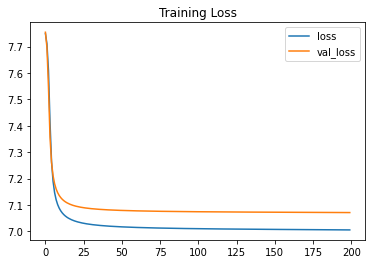

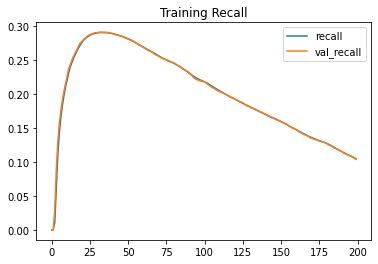

In [46]:
cfrnn.plot_training()

---
## Continue training from checkpoint

### Load Weights

In [ ]:
cfrnn = CFRNN(total_users, total_items, params)
cfrnn.build_model(ckpt_dir=cfrnn.ckpt_dir)
cfrnn.compile_model()

In [23]:
init_epoch = 55
cfrnn.params['epochs'] = 100
cfrnn.epochs = 100

### Continue Training

In [ ]:
cfrnn.train(train_dataset, val_dataset, initial_epoch=init_epoch)

---
# Predict Sequences

In [47]:
from Evaluation import get_metrics

## Restore Latest Checkpoints

In [48]:
test_half_indices = []
pred_half_indices = []
for user_id in test_set.user_id.unique():
    df_user = test_set[test_set['user_id'] == user_id]
#     split = np.array_split(df_user, 2)
#     test_half_indices.extend(split[0].index)
#     pred_half_indices.extend(split[1].index[:1])
    test_half_indices.extend(df_user.iloc[:-1].index)
    pred_half_indices.extend(df_user.iloc[-1:].index)
    
test_half = test_set.loc[test_half_indices]
pred_half = test_set.loc[pred_half_indices]    

In [49]:
preds_df = cfrnn.get_predictions(train_set, test_half, pred_half, batch_size = 1000, rank_at = 20, ckpt_dir = '../CFRNN_storage/ckpts')

In [164]:
get_metrics(preds_df, ndcg=False)

Obtaining metrics time: 0.38


,rank_at,hitcounts,recall,precision
0,1,4,0.008,0.0080
1,5,23,0.046,0.0092
2,10,45,0.090,0.0090
3,15,63,0.126,0.0084
4,20,76,0.152,0.0076


In [27]:
get_metrics(preds_df, ndcg=False)

Obtaining metrics time: 0.73


,rank_at,hitcounts,recall,precision
0,1,3,0.003,0.003000
1,5,22,0.022,0.004400
2,10,47,0.047,0.004700
3,15,73,0.073,0.004867
4,20,92,0.092,0.004600


In [50]:
preds_df

,user,pred_items_ranked,true_id
0,1,"[2785, 2511, 2557, 1485, 2898, 253, 1148, 1178...",[1737]
1,17,"[466, 2785, 2557, 2203, 2374, 579, 309, 1178, ...",[1546]
2,21,"[0, 579, 2162, 2480, 49, 513, 2958, 3177, 3248...",[849]
3,22,"[2898, 1120, 2775, 1848, 1178, 346, 2511, 2959...",[2441]
4,28,"[2203, 593, 3341, 579, 2651, 1173, 2775, 1848,...",[2354]
...,...,...,...
995,6025,"[287, 1173, 3341, 1485, 1848, 106, 2203, 3550,...",[1142]
996,6027,"[2203, 579, 2785, 593, 1449, 3341, 2426, 2557,...",[2788]
997,6035,"[0, 802, 3341, 513, 346, 287, 3550, 2748, 1131...",[3337]
998,6037,"[3341, 593, 2557, 2426, 2203, 2651, 579, 1106,...",[1094]


In [52]:
get_metrics(preds_df, ndcg=False).to_pickle('../Results/metrics_ml_1m_cfrnn')

Obtaining metrics time: 0.71


---
# Store Results

In [ ]:
from Models import store_LSTM_model
# store_path = path + 'results/CFRNN/' + res_ext + '/all_models'
store_path = path + 'results/' + res_ext + '/all_models'
train_time = np.sum(timing_callback.logs)
all_models = store_LSTM_model(store_path, params.copy(), history.history.copy(), train_time, metrics_test, store=True)

In [ ]:
all_models

In [36]:
metrics_val_set_vsl = get_metrics(preds_val, 5, 20)
metrics_val_set_vsl

Obtaining metrics time: 1.12


,rank_at,hitcounts,recall,precision
0,1,1,0.000601,0.000601
1,5,8,0.004808,0.000962
2,10,15,0.009014,0.000901
3,15,21,0.012620,0.000841
4,20,27,0.016226,0.000811


# Appendix

In [ ]:
# oh_input = tf.keras.backend.one_hot(padded, n_items)
# e = tf.keras.layers.Embedding(n_items, 100, input_length=max_l)

In [ ]:
# One hot encoded input
# sequences_data_x = tf.data.Dataset.from_tensor_slices(tf.keras.backend.one_hot(padded_sequences_x, n_items)) 
# sequences_data_y = tf.data.Dataset.from_tensor_slices(tf.keras.backend.one_hot(padded_sequences_y, n_items)) 

In [ ]:
# max_seq_len = 30
# min_seq_len = 10
# shift_targets_by = 1

# from Data_prep import get_x_y_sequences, min_padding
# vsl = True # Set for training later

# # Train Set
# user_sequences_x, user_sequences_y, user_order = get_x_y_sequences(train_set, shift_targets_by)
# padded_sequences_x = min_padding(user_sequences_x, BATCH_SIZE, min_seq_len, max_seq_len)
# padded_sequences_y = min_padding(user_sequences_y, BATCH_SIZE, min_seq_len, max_seq_len)

# # Val Set 
# user_sequences_val_x, user_sequences_val_y, user_order = get_x_y_sequences(val_set, shift_targets_by, stats=False)
# padded_sequences_val_x = min_padding(user_sequences_val_x, BATCH_SIZE, min_seq_len, max_seq_len)
# padded_sequences_val_y = min_padding(user_sequences_val_y, BATCH_SIZE, min_seq_len, max_seq_len)

In [ ]:
# test_set_u_i = test_set.groupby('user_id')['item_id'].apply(list)
# test_X = []
# test_y = []
# all_predictions = []
# for user_items in test_set_u_i:
#     test_X.append(user_items[-200:-1])
#     test_y.append(user_items[-1:])

# for i, seq in enumerate(test_X): 
#     seq = seq.copy()
#     predictions = []
#     for i in range(20):
#         pred_item_id = model.predict_classes(np.array([seq,]), batch_size=1)[0]
#         seq.append(pred_item_id)
#         predictions.append(pred_item_id)
#     all_predictions.append(predictions)
    
# predictions_df = pd.DataFrame(list(zip(test_set.user_id.unique(), all_predictions, test_y)),
#                               columns=['user', 'pred_items_ranked', 'true_id'])